In [1]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import os
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from dotmotif.ingest import CSVEdgelistConverter
from scipy import stats

In [2]:
raw_data = pd.read_feather('../data/Microns In Vivo Correlation Data v2/cell_cell_correlations.feather')
raw_data = raw_data.drop_duplicates(subset=['pt_root_id_1', 'pt_root_id_2'], keep='first')
# raw_data.columns
raw_data['pt_root_id_1'].dtype
# drop duplicates

raw_data = pd.concat([raw_data, raw_data.rename({'pt_root_id_1': 'pt_root_id_2', 'pt_root_id_2': 'pt_root_id_1'})]).reset_index(drop=True)
raw_data

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,864691135348268503,864691135700505634,0.018631,7,4
1,864691135348268503,864691135776919981,-0.005178,7,4
2,864691135348268503,864691135472842290,0.006708,7,4
3,864691135348268503,864691135349237975,0.020941,7,4
4,864691135345445279,864691135348268503,0.008743,7,4
...,...,...,...,...,...
13007153,864691135715713562,864691136267470324,0.058886,3,7
13007154,864691135715713562,864691135778113213,0.020464,3,7
13007155,864691135697182106,864691136267470324,0.011063,3,7
13007156,864691135697182106,864691135778113213,-0.029825,3,7


In [3]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "../data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [4]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)
print(coreg_in_silico.shape)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
print(prf_df.shape)
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
workshop2file = 'all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])

(12094, 23)
(1051, 10)


In [5]:
all_syn_dfm2.index_pre

0         1732
1         9201
2        10852
4         2145
5         2091
         ...  
36266      323
36270      323
36278      394
36282     8949
36283     8949
Name: index_pre, Length: 24782, dtype: int64

In [6]:
resp

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
row_idx,,,,,,,,,,,,,,,,,,,,,
0,9.819719,9.572107,9.575624,9.747010,9.971255,9.851794,10.146152,10.441845,10.554578,10.590077,...,10.074213,9.852283,9.957593,10.008598,9.929258,9.856516,9.963867,9.899036,9.846794,9.755130
1,5.824135,5.336558,5.128190,5.203142,5.506340,5.930792,6.528087,6.857086,7.117443,7.385743,...,5.238009,5.207496,5.200150,5.162911,5.277632,5.155036,5.286361,5.119339,5.125288,5.078022
2,5.691068,5.529594,5.803073,6.178924,6.443235,6.469791,6.654843,6.811019,6.661856,6.376816,...,5.361619,5.108631,4.880289,4.721966,4.654217,4.591662,4.486180,4.514648,4.727315,5.012149
3,3.548255,3.565851,3.518249,3.360956,2.990964,2.775848,2.678332,2.665106,2.672216,2.675659,...,3.610325,3.597228,3.585626,3.641256,3.775688,3.861930,3.925865,3.802548,3.864862,3.896344
4,6.361384,6.344265,6.517450,6.768298,6.822587,6.806442,7.249547,7.614173,7.614393,7.706423,...,6.779241,6.837814,6.838259,6.975827,6.713204,6.575862,6.436296,6.197456,6.013506,5.949809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104166,7.371026,7.391239,7.418334,7.503781,7.600024,7.725336,7.553344,7.385557,7.279595,7.234358,...,6.784002,6.663013,6.410810,6.328493,6.312036,6.344944,6.185144,6.152516,6.210687,6.497430
104167,36.203568,34.035812,31.154234,28.341587,27.045757,25.960541,25.018373,23.971766,23.934450,24.305433,...,29.859049,31.423447,31.123848,31.880001,32.174137,31.562712,31.853586,31.688009,31.952732,33.268524
104168,9.263451,9.338160,9.252237,8.782646,8.660838,8.405701,8.518544,8.542967,8.370674,8.318182,...,10.316454,10.185993,10.024368,9.652556,9.294561,8.994209,8.627438,8.604503,8.576520,8.645331


In [7]:
print(coreg_resp.values.shape)
print(corr_M.shape)

(12094, 5000)
(12094, 12094)


In [8]:
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [9]:
condensed = all_syn_dfm3[['pre_pt_root_id','post_pt_root_id','sum_size','index_pre','index_post','C','cell_type_pre','cell_type_post']]
condensed.to_csv('edgelist_corr_cell_types.csv')
CSV_EDGELIST = 'edgelist_corr_cell_types.csv'
condensed

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5ET,L5ET


In [10]:

# # Difine Dict with the key-value pair to remap.
# dict = {"Spark" : 'S', "PySpark" : 'P', "Hadoop": 'H', "Python" : 'P', "Pandas": 'P'}
# df2=df.replace({"Courses": dict})
# print(df2)
remap_dict = {'L2a':'L2/3', 'L2b':'L2/3', 
              'L3a':'L2/3', 'L3b':'L2/3', 'L3c':'L2/3', 
              'L4a':'L4', 'L4b':'L4', 'L4c':'L4',
              'L5ET':'L5', 'L5NP':'L5', 'L5a':'L5', 'L5b':'L5',
              'L6CT':'L6','L6a':'L6', 'L6b':'L6'}

df = condensed.replace({'cell_type_pre':remap_dict})
df = df.replace({'cell_type_post':remap_dict})
df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4,L5
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2/3,L5
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4,L5
...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5,L5
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5,L4
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5,L2/3
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5,L5


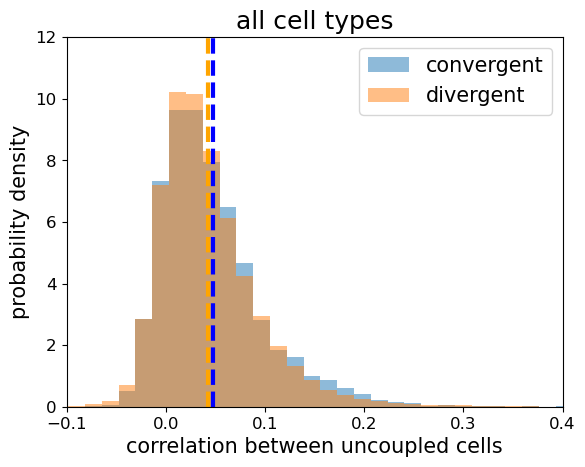

In [11]:
df.to_csv('all.csv')
CSV_EDGELIST_all = 'all.csv'
graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_all,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()
# Create the search engine.
E_all = GrandIsoExecutor(graph=graph_thresh)
con_motif = Motif("""
A -> C
B -> C
""")
con_results = E_all.find(con_motif)
n_con = len(con_results)
div_motif = Motif("""
B -> A
B -> C
""")
div_results = E_all.find(div_motif)
n_div = len(div_results)
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results),dtype=np.int64)
for i, con_motif in enumerate(con_results):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results),dtype=np.int64)
for i, div_motif in enumerate(div_results):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
con_corr_df = con_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_df = div_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
fig,ax = plt.subplots()
con_corrs = con_corr_df[['corr']]
div_corrs = div_corr_df[['corr']]
ax.hist(con_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
con_mean = np.mean(con_corrs)
div_mean = np.mean(div_corrs)
ax.vlines(con_mean,0,12,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean,0,12,linestyle='--',linewidth=3,color='orange')
ax.set_title('all cell types',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,12])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
plt.savefig('motifCorrs_allCellTypes.png',bbox_inches='tight',dpi=200)
plt.show()

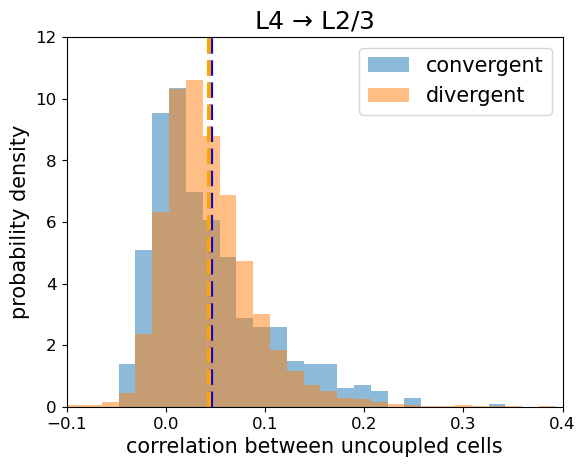

In [12]:
L4toL23_df = df[ (df['cell_type_pre'] == 'L4') & (df['cell_type_post'] == 'L2/3')]
# L4toL23_df
L4toL23_df.to_csv('L4toL23.csv')
CSV_EDGELIST_L4toL23 = 'L4toL23.csv'
graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L4toL23,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()
# Create the search engine.
E = GrandIsoExecutor(graph=graph_thresh)
con_motif = Motif("""
A -> C
B -> C
""")
con_results = E.find(con_motif)
n_con = len(con_results)
div_motif = Motif("""
B -> A
B -> C
""")
div_results = E.find(div_motif)
n_div = len(div_results)
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results),dtype=np.int64)
for i, con_motif in enumerate(con_results):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results),dtype=np.int64)
for i, div_motif in enumerate(div_results):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
con_corr_df = con_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_df = div_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
fig,ax = plt.subplots()
con_corrs = con_corr_df[['corr']]
div_corrs = div_corr_df[['corr']]
ax.hist(con_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
con_mean = np.mean(con_corrs)
div_mean = np.mean(div_corrs)
ax.vlines(con_mean,0,12,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean,0,12,linestyle='--',linewidth=3,color='orange')
ax.set_title(r'L4 $\to$ L2/3',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,12])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
plt.savefig('motifCorrs_L4toL23.png',bbox_inches='tight',dpi=200)
plt.show()


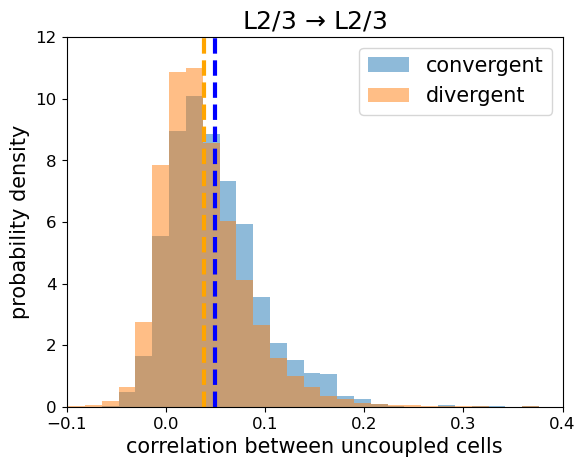

In [21]:
L23toL23_df = df[ (df['cell_type_pre'] == 'L2/3') & (df['cell_type_post'] == 'L2/3')]
# L4toL23_df
L23toL23_df.to_csv('L23toL23.csv')
CSV_EDGELIST_L23toL23 = 'L23toL23.csv'
graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L23toL23,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()
# Create the search engine.
E = GrandIsoExecutor(graph=graph_thresh)
con_motif = Motif("""
A -> C
B -> C
""")
con_results = E.find(con_motif)
n_con = len(con_results)
div_motif = Motif("""
B -> A
B -> C
""")
div_results = E.find(div_motif)
n_div = len(div_results)
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results),dtype=np.int64)
for i, con_motif in enumerate(con_results):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results),dtype=np.int64)
for i, div_motif in enumerate(div_results):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
con_corr_df = con_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_df = div_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
fig,ax = plt.subplots()
con_corrs = con_corr_df[['corr']]
div_corrs = div_corr_df[['corr']]
ax.hist(con_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
con_mean = np.mean(con_corrs)
div_mean = np.mean(div_corrs)
ax.vlines(con_mean,0,12,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean,0,12,linestyle='--',linewidth=3,color='orange')
ax.set_title(r'L2/3 $\to$ L2/3',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,12])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
plt.savefig('motifCorrs_L23toL23.png',bbox_inches='tight',dpi=200)
plt.show()


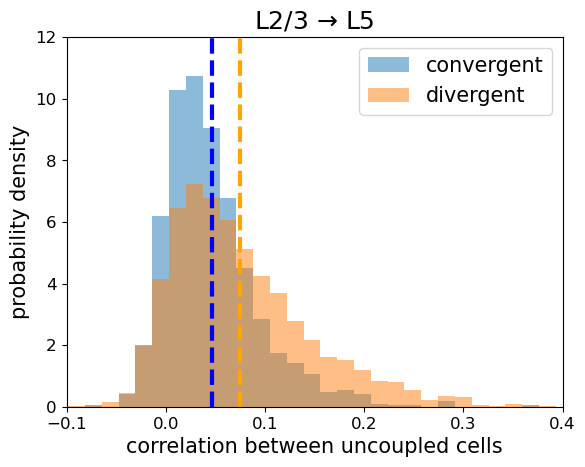

In [23]:
L23toL5_df = df[ (df['cell_type_pre'] == 'L2/3') & (df['cell_type_post'] == 'L5')]
# L4toL23_df
L23toL5_df.to_csv('L23toL5.csv')
CSV_EDGELIST_L23toL5 = 'L23toL5.csv'
graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L23toL5,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()
# Create the search engine.
E = GrandIsoExecutor(graph=graph_thresh)
con_motif = Motif("""
A -> C
B -> C
""")
con_results = E.find(con_motif)
n_con = len(con_results)
div_motif = Motif("""
B -> A
B -> C
""")
div_results = E.find(div_motif)
n_div = len(div_results)
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results),dtype=np.int64)
for i, con_motif in enumerate(con_results):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results),dtype=np.int64)
for i, div_motif in enumerate(div_results):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
con_corr_df = con_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_df = div_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
fig,ax = plt.subplots()
con_corrs = con_corr_df[['corr']]
div_corrs = div_corr_df[['corr']]
ax.hist(con_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
con_mean = np.mean(con_corrs)
div_mean = np.mean(div_corrs)
ax.vlines(con_mean,0,12,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean,0,12,linestyle='--',linewidth=3,color='orange')
ax.set_title(r'L2/3 $\to$ L5',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,12])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
plt.savefig('motifCorrs_L23toL5.png',bbox_inches='tight',dpi=200)
plt.show()


In [ ]:
ctr = condensed_thresholded_remapped
L23toL23_df = ctr[ (ctr['cell_type_pre'] == 'L2/3') & (ctr['cell_type_post'] == 'L2/3')]
L23toL23_df

In [ ]:
ctr = condensed_thresholded_remapped
L23toL5_df = ctr[ (ctr['cell_type_pre'] == 'L2/3') & (ctr['cell_type_post'] == 'L5')]
L23toL5_df

In [ ]:
L23toL5_df.to_csv('L23toL5_df.csv')
CSV_EDGELIST_L23toL5_df = 'L23toL5_df.csv'

In [ ]:
L4toL23_df.to_csv('L4toL23_df.csv')
CSV_EDGELIST_L4toL23_df = 'L4toL23_df.csv'

In [ ]:
L23toL23_df.to_csv('L23toL23_df.csv')
CSV_EDGELIST_L23toL23_df = 'L23toL23_df.csv'

In [ ]:
# repeat motif analysis for raw data

graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L23toL5_df,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()

# Create the search engine.
E_L23toL5 = GrandIsoExecutor(graph=graph_thresh)

In [ ]:
# repeat motif analysis for raw data

graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L4toL23_df,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()

# Create the search engine.
E_L4toL23 = GrandIsoExecutor(graph=graph_thresh)

In [ ]:
# repeat motif analysis for raw data

graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L23toL23_df,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()

# Create the search engine.
E_L23toL23 = GrandIsoExecutor(graph=graph_thresh)

In [ ]:

# 'L2/3', 'L4', 'L5', 'L6'
con_motif = Motif("""
A -> C
B -> C
""")

con_results_thresh = E_L23toL5.find(con_motif)
n_con = len(con_results_thresh)

div_motif = Motif("""
B -> A
B -> C
""")

div_results_thresh = E_L23toL5.find(div_motif)
n_div = len(con_results_thresh)

In [ ]:

# 'L2/3', 'L4', 'L5', 'L6'
con_motif = Motif("""
A -> C
B -> C
""")

con_results_thresh = E_L4toL23.find(con_motif)
n_con = len(con_results_thresh)

div_motif = Motif("""
B -> A
B -> C
""")

div_results_thresh = E_L4toL23.find(div_motif)
n_div = len(con_results_thresh)

In [ ]:

# 'L2/3', 'L4', 'L5', 'L6'
con_motif = Motif("""
A -> C
B -> C
""")

con_results_thresh = E_L23toL23.find(con_motif)
n_con = len(con_results_thresh)

div_motif = Motif("""
B -> A
B -> C
""")

div_results_thresh = E_L23toL23.find(div_motif)
n_div = len(con_results_thresh)

In [ ]:
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results_thresh),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results_thresh),dtype=np.int64)
for i, con_motif in enumerate(con_results_thresh):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df_thresh = pd.DataFrame(data=d)
con_df_thresh

In [ ]:
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results_thresh),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results_thresh),dtype=np.int64)
for i, div_motif in enumerate(div_results_thresh):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df_thresh = pd.DataFrame(data=d)
div_df_thresh

In [ ]:
con_corr_raw_thresh_df = con_df_thresh.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
con_corr_raw_thresh_df

In [ ]:
div_corr_raw_thresh_df = div_df_thresh.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_raw_thresh_df

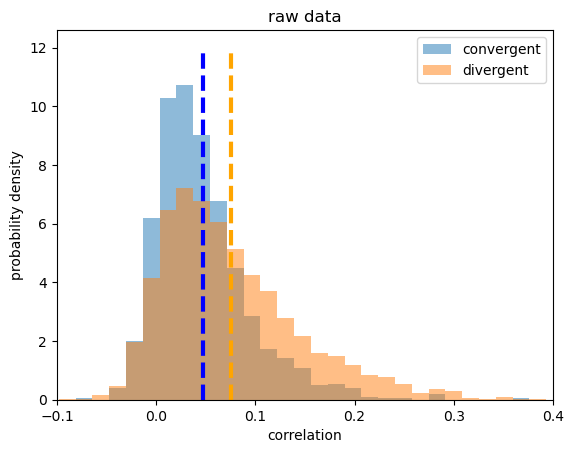

In [122]:
fig,ax = plt.subplots()
con_corrs_raw_thresh = con_corr_raw_thresh_df[['corr']]
div_corrs_raw_thresh = div_corr_raw_thresh_df[['corr']]
ax.hist(con_corrs_raw_thresh,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs_raw_thresh,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
# ax.hist(con_corrs_raw_thresh,density=True,label='convergent',alpha=0.5)
# ax.hist(div_corrs_raw_thresh,density=True,label='divergent',alpha=0.5)
con_mean_thresh = np.mean(con_corrs_raw_thresh)
div_mean_thresh = np.mean(div_corrs_raw_thresh)
ax.vlines(con_mean_thresh,0,12,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean_thresh,0,12,linestyle='--',linewidth=3,color='orange')
# print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
ax.set_title('raw data')
ax.set_xlabel('correlation')
ax.set_ylabel('probability density')
ax.set_xlim([-0.1,0.4])
plt.legend()
plt.savefig('rawDataMotifCorrsL23to5.png',bbox_inches='tight',dpi=200)
plt.show()

In [86]:
con_mean_thresh

0.045549894972434585

In [14]:
# motif = Motif("""
# A -> B [spine_vol_um3 > 0.25]
# B -> C
# C -> A
# """)

con_motif = Motif("""
A -> C
B -> C
""")

con_results = E.find(con_motif)
n_con = len(con_results)

div_motif = Motif("""
B -> A
B -> C
""")

div_results = E.find(div_motif)
n_div = len(div_results)


In [15]:
# con_results

In [16]:
corr_M.shape

(12094, 12094)

In [17]:
con_corrs = []
for con_motif in con_results:
    aid = int(con_motif['A'])
    bid = int(con_motif['B'])
    con_corr = corr_M[aid, bid]
    con_corrs.append(con_corr)

div_corrs = []
for div_motif in div_results:
    aid = int(div_motif['A'])
    cid = int(div_motif['C'])
    div_corr = corr_M[aid, cid]
    div_corrs.append(div_corr)


In [18]:
fig, ax = plt.subplots()
ax.hist(con_corrs,label='convergent',alpha=0.5,density=True,bins=30)
con_mean = np.mean(con_corrs)
# plt.vlines
ax.hist(div_corrs,label='divergent',alpha=0.5,density=True,bins=30)
ax.set_xlabel('correlation')
ax.set_ylabel('probability density')
res = stats.ks_2samp(con_corrs, div_corrs)
print(res)
ax.legend()
plt.show()

KstestResult(statistic=0.05886773833320247, pvalue=0.0, statistic_location=0.1004403088995109, statistic_sign=1)


In [31]:
# repeat motif analysis for raw data

graph = CSVEdgelistConverter(
    CSV_EDGELIST,
    # Tell DotMotif which columns represent the "source" and "target"
    # of the edgelist:
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()

# Create the search engine.
E = GrandIsoExecutor(graph=graph)

In [24]:
# motif = Motif("""
# A -> B [spine_vol_um3 > 0.25]
# B -> C
# C -> A
# """)

con_motif = Motif("""
A -> C
B -> C
""")

con_results_raw = E.find(con_motif)
n_con_raw = len(con_results_raw)

div_motif = Motif("""
B -> A
B -> C
""")

div_results_raw = E.find(div_motif)
n_div_raw = len(div_results_raw)


In [ ]:
# >>> d = {'col1': [1, 2], 'col2': [3, 4]}
# >>> df = pd.DataFrame(data=d)
# >>> df
#    col1  col2
# 0     1     3
# 1     2     4

In [ ]:
con_idcs = pd.

In [57]:
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results_raw))
d['pt_root_id_2'] = np.zeros(len(con_results_raw))
for i, con_motif in enumerate(con_results_raw):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
con_df

,pt_root_id_1,pt_root_id_2
0,8.646911e+17,8.646911e+17
1,8.646911e+17,8.646911e+17
2,8.646911e+17,8.646911e+17
3,8.646911e+17,8.646911e+17
4,8.646911e+17,8.646911e+17
...,...,...
152055,8.646911e+17,8.646911e+17
152056,8.646911e+17,8.646911e+17
152057,8.646911e+17,8.646911e+17
152058,8.646911e+17,8.646911e+17


In [68]:
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results_raw))
d['pt_root_id_2'] = np.zeros(len(div_results_raw))
for i, div_motif in enumerate(div_results_raw):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
div_df

,pt_root_id_1,pt_root_id_2
0,8.646911e+17,8.646911e+17
1,8.646911e+17,8.646911e+17
2,8.646911e+17,8.646911e+17
3,8.646911e+17,8.646911e+17
4,8.646911e+17,8.646911e+17
...,...,...
1849873,8.646911e+17,8.646911e+17
1849874,8.646911e+17,8.646911e+17
1849875,8.646911e+17,8.646911e+17
1849876,8.646911e+17,8.646911e+17


In [64]:
con_corr_raw_df = con_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
con_corr_raw_df

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,8.646911e+17,8.646911e+17,0.004555,6,5
1,8.646911e+17,8.646911e+17,0.004555,6,5
2,8.646911e+17,8.646911e+17,-0.008219,6,5
3,8.646911e+17,8.646911e+17,-0.008219,6,5
4,8.646911e+17,8.646911e+17,0.096855,5,8
...,...,...,...,...,...
18521,8.646911e+17,8.646911e+17,0.149102,7,4
18522,8.646911e+17,8.646911e+17,0.091731,6,5
18523,8.646911e+17,8.646911e+17,0.091731,6,5
18524,8.646911e+17,8.646911e+17,0.047078,6,6


In [69]:
div_corr_raw_df = div_df.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_raw_df

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,8.646911e+17,8.646911e+17,0.054331,4,6
1,8.646911e+17,8.646911e+17,0.054331,4,6
2,8.646911e+17,8.646911e+17,0.016787,6,5
3,8.646911e+17,8.646911e+17,0.016787,6,5
4,8.646911e+17,8.646911e+17,0.081727,4,9
...,...,...,...,...,...
216219,8.646911e+17,8.646911e+17,0.010468,7,4
216220,8.646911e+17,8.646911e+17,0.114544,5,7
216221,8.646911e+17,8.646911e+17,0.114544,5,7
216222,8.646911e+17,8.646911e+17,0.040368,4,6


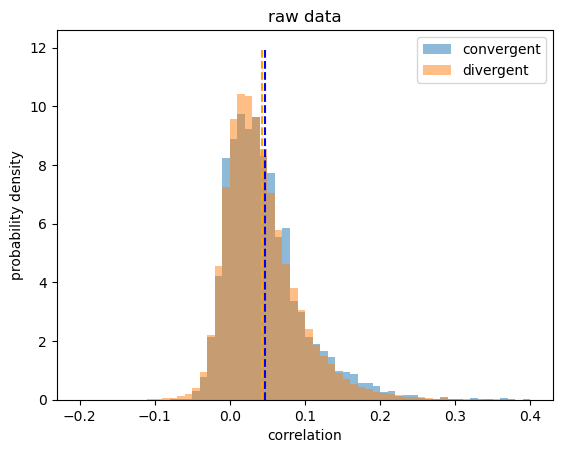

In [86]:
fig,ax = plt.subplots()
con_corrs_raw = con_corr_raw_df[['corr']]
div_corrs_raw = div_corr_raw_df[['corr']]
ax.hist(con_corrs_raw,density=True,bins=np.linspace(-.2, .4, 61),label='convergent',alpha=0.5)
ax.hist(div_corrs_raw,density=True,bins=np.linspace(-.2, .4, 61),label='divergent',alpha=0.5)
con_mean = np.mean(con_corrs_raw)
div_mean = np.mean(div_corrs_raw)
ax.vlines(con_mean,0,12,linestyle='--',color='blue')
ax.vlines(div_mean,0,12,linestyle='--',color='orange')
# print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
ax.set_title('raw data')
ax.set_xlabel('correlation')
ax.set_ylabel('probability density')
plt.legend()
plt.savefig('rawDataMotifCorrs.png',bbox_inches='tight',dpi=200)
plt.show()

In [74]:
con_corrs_raw.shape

(18526, 1)

In [75]:
div_corrs_raw.shape

(216224, 1)

In [78]:
con_corrs_raw_flat = np.array(con_corrs_raw).flatten()
div_corrs_raw_flat = np.array(div_corrs_raw).flatten()
print(stats.ks_2samp(con_corrs_raw_flat, div_corrs_raw_flat))

KstestResult(statistic=0.03248229819637105, pvalue=4.465699386484831e-16, statistic_location=0.05394840178295175, statistic_sign=-1)


In [47]:
con_corrs_raw = []
for con_motif in con_results_raw:
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    # print(aid)
    # print(bid)
    # con_corr = corr_M[aid, bid]
    con_corr_raw = raw_data[(raw_data['pt_root_id_1'] == aid) & (raw_data['pt_root_id_2'] == bid)][['corr']]
    # print(con_corr_raw)
    con_corrs_raw.append(con_corr_raw)

# div_corrs = []
# for div_motif in div_results:
#     aid = int(div_motif['A'])
#     cid = int(div_motif['C'])
#     div_corr = corr_M[aid, cid]
#     div_corrs.append(div_corr)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.hist(con_corrs_raw, label='convergent', alpha=0.5, density=True, bins=30)

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
    
setattr(Axes3D, 'arrow3D', _arrow3D)

In [5]:
all_syn_dfm.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position'],
      dtype='object')

In [6]:
coreg_df.columns

Index(['id', 'created', 'valid', 'target_id', 'session', 'scan_idx', 'unit_id',
       'field', 'residual', 'score', 'id_ref', 'created_ref', 'valid_ref',
       'volume', 'pt_supervoxel_id', 'pt_root_id', 'pt_position',
       'bb_start_position', 'bb_end_position'],
      dtype='object')

In [7]:
nuc_df2 = client.materialize.query_view('nucleus_detection_lookup_v1',
                                       desired_resolution=[1000,1000,1000])
nuc_df2
                                        # select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        # desired_resolution=[1000,1000,1000])

,id,volume,pt_root_id,orig_root_id,pt_supervoxel_id,pt_position,pt_position_lookup
0,730537,32.307937,0,0,0,"[1525.248, 1095.936, 799.72]","[1525.248, 1095.936, 799.72]"
1,373879,229.045043,864691136090135607,864691136090135607,96218056992431305,"[915.264, 959.104, 783.72]","[915.264, 959.104, 783.72]"
2,601340,426.138010,0,0,0,"[1360.0, 1116.608, 837.84]","[1360.0, 1116.608, 837.84]"
3,201858,93.753836,864691135373893678,864691135373893678,84955554103121097,"[587.392, 854.4, 1050.68]","[587.392, 854.4, 1050.68]"
4,600774,135.189791,864691135682378744,0,111493022281121981,"[1356.48, 1104.448, 777.68]","[1358.08, 1105.92, 780.24]"
...,...,...,...,...,...,...,...
144115,598753,792.030249,864691135743752909,864691135743752909,110506897924421202,"[1330.304, 1076.864, 829.32]","[1330.304, 1076.864, 829.32]"
144116,111162,800.065782,864691134912248365,864691134912248365,79244553336437996,"[421.376, 521.6, 1068.84]","[421.376, 521.6, 1068.84]"
144117,795176,828.325233,0,0,0,"[1645.888, 841.344, 1003.64]","[1645.888, 841.344, 1003.64]"
144118,528334,896.589660,864691135968943973,864691135968943973,105853763977769997,"[1194.432, 813.952, 610.68]","[1194.432, 813.952, 610.68]"


In [8]:
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [9]:
clean_coreg_df.shape

(583, 32)

In [10]:
clean_coreg_df

,id_x,created_x,superceded_id,valid_x,valid_id,status_dendrite,status_axon,pt_supervoxel_id_x,pt_root_id,pt_position_x,...,residual,score,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id_y,pt_position_y,bb_start_position,bb_end_position
0,295,2023-04-05 04:49:26.555498+00:00,NaN,t,864691135397542177,extended,clean,89245092023510260,864691135927049742,"[178112, 191344, 22109]",...,9.06328,9.837156,265045,2020-09-28 22:41:22.169095+00:00,t,368.404562,89245092023510260,"[712.448, 765.376, 884.36]","[nan, nan, nan]","[nan, nan, nan]"
1,1269,2023-04-06 05:09:05.153458+00:00,NaN,t,864691135122603047,extended,extended,91346396048860133,864691135122603047,"[193152, 118976, 21021]",...,2.79599,12.003761,292685,2020-09-28 22:42:22.764949+00:00,t,326.725140,91346396048860133,"[772.608, 475.904, 840.84]","[nan, nan, nan]","[nan, nan, nan]"
2,1269,2023-04-06 05:09:05.153458+00:00,NaN,t,864691135122603047,extended,extended,91346396048860133,864691135122603047,"[193152, 118976, 21021]",...,12.45100,1.271139,292685,2020-09-28 22:42:22.764949+00:00,t,326.725140,91346396048860133,"[772.608, 475.904, 840.84]","[nan, nan, nan]","[nan, nan, nan]"
3,1270,2023-04-06 05:09:05.154604+00:00,NaN,t,864691135155894884,extended,extended,87475840375371574,864691135155894884,"[165408, 116672, 22032]",...,11.48900,-3.487494,256576,2020-09-28 22:44:34.228127+00:00,t,263.234191,87475840375371574,"[661.632, 466.688, 881.28]","[nan, nan, nan]","[nan, nan, nan]"
4,1271,2023-04-06 05:09:05.156001+00:00,NaN,t,864691135591041291,extended,extended,86913165367478600,864691135591041291,"[161168, 118496, 22997]",...,5.78571,2.095723,222998,2020-09-28 22:45:05.514269+00:00,t,316.776940,86913165367478600,"[644.672, 473.984, 919.88]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,1246,2023-04-05 04:49:27.451383+00:00,NaN,t,864691136990522517,extended,extended,93177907207497424,864691136990522517,"[206577, 133261, 18640]",...,7.76225,0.238802,327859,2020-09-28 22:43:18.009653+00:00,t,268.365169,93177907207502813,"[826.304, 532.672, 745.8]","[nan, nan, nan]","[nan, nan, nan]"
579,1251,2023-04-05 04:49:27.455773+00:00,NaN,t,864691137019596142,extended,extended,92619630044487968,864691137019596142,"[202346, 167997, 17807]",...,4.52099,6.761626,332199,2020-09-28 22:41:22.584854+00:00,t,234.467328,92619630044497997,"[809.408, 672.064, 712.6]","[nan, nan, nan]","[nan, nan, nan]"
580,1257,2023-04-05 04:49:27.461276+00:00,NaN,t,864691137020787054,clean,clean,91212530441577788,864691137020787054,"[192400, 170160, 20939]",...,5.86964,6.321741,298831,2020-09-28 22:43:09.131628+00:00,t,299.476582,91212530441577788,"[769.6, 680.64, 837.56]","[nan, nan, nan]","[nan, nan, nan]"
581,1261,2023-04-05 04:49:27.464778+00:00,NaN,t,864691137054388086,extended,clean,90229429674273122,864691137054388086,"[185152, 185344, 21255]",...,8.06943,0.228558,301095,2020-09-28 22:45:17.936978+00:00,t,365.151191,90229429674273122,"[740.608, 741.376, 850.2]","[nan, nan, nan]","[nan, nan, nan]"


In [10]:
all_syn_df = pd.read_pickle('all_prf_coreg_conn_v661.pkl')
all_syn_df.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Connection Connectivity Column Descriptions:
* pre_pt_root_id: the segmentation ID of the pre-synaptic compartment
* post_pt_root_id: the segmentation ID of the post-synaptic compartment
* n_syn: how many synapses in this connection
* sum_size: a metric (AU) of the total amount of synaptic area between these neurons. Proportional to connection weight.
* pre_nuc_id: if not -1, then this pre_pt_root_id maps to exactly one cell body with a neuronal nucleus.
* post_nuc_id: if not -1, then this post_pt_root_id maps to exactly one cell body with a neuronal nucleus.

If pre/post_nuc_id = -1 then its either an orphan (i.e. a spine head or axon fragment) or a multi-neuron segmentation object (rare).

In [11]:
# nice to just have a list of all the nuclei and their positions
# I'm just going to pull out 3 columns that we need
# note this asks for positions in units of microns (1000nm per unit in x,y,z)
nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Nucleus Table Column descriptions:
Many of these you have seen before, because they were merged automatically for table that referenced them
* **id**: the nucleus id
* **pt_rood_id**: the segmentation id of the nuclues (0 if its outside the segmentation)
* **pt_position**: the position (in microns because desired_resolution=[1000,1000,1000]

  </div>

In [12]:
# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)


In [13]:
all_syn_dfm.shape

(121720, 8)

In [14]:
all_syn_dfm.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position'],
      dtype='object')

In [15]:
# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,unit_id_pre,score_pre,residual_pre,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,7305,9.837156,9.06328,9470,8,5,8,9995,4.829187,12.58870
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,7920,-6.800207,12.60420,9470,8,5,8,9995,4.829187,12.58870
2,864691135122603047,864691136310417242,1,23668,292685,303145,"[772.608, 475.904, 840.84]","[742.528, 824.896, 890.64]",10852,9,...,2231,12.003761,2.79599,9470,8,5,8,9995,4.829187,12.58870
4,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,2177,-3.487494,11.48900,9470,8,5,8,9995,4.829187,12.58870
5,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,1926,2.095723,5.78571,9470,8,5,8,9995,4.829187,12.58870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,864691135468161164,864691135661345776,1,8012,553469,420773,"[1273.152, 501.12, 865.92]","[997.12, 417.024, 914.52]",323,4,...,3404,8.345294,4.46736,3987,6,4,2,1381,5.763388,5.06218
36270,864691135468161164,864691135416233914,1,1160,553469,555010,"[1273.152, 501.12, 865.92]","[1292.864, 518.4, 868.76]",323,4,...,3404,8.345294,4.46736,5308,6,6,4,3609,3.216549,10.36870
36278,864691135518453642,864691135645524719,1,3852,610607,261495,"[1382.272, 494.656, 840.6]","[705.152, 687.168, 620.12]",394,4,...,3586,-1.946791,7.53477,5794,6,6,6,6613,6.596697,2.31381
36282,864691136136766845,864691136066510488,1,188,583729,610337,"[1367.744, 515.072, 736.64]","[1418.816, 459.712, 741.36]",8949,8,...,5181,2.960362,5.85307,7950,7,5,2,2048,2.100361,9.59625


In [16]:
# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]

In [17]:
uni_preIDs = np.unique(all_syn_dfm2[['pre_pt_root_id']])
Npre = len(uni_preIDs)
print(Npre)
uni_postIDs = np.unique(all_syn_dfm2[['post_pt_root_id']])
Npost = len(uni_postIDs)
print(Npost)
uni_preIDs = set(uni_preIDs.flatten())
uni_postIDs = set(uni_postIDs.flatten())
uniqueIDs = uni_preIDs.union(uni_postIDs)
uniqueIDs = np.array(list(uniqueIDs))
N = len(uniqueIDs)
remapDict = {}
for i in range(N):
    remapDict[uniqueIDs[i]] = i
df2 = all_syn_dfm2.replace({"pre_pt_root_id": remapDict})
df2 = df2.replace({"post_pt_root_id": remapDict})
df2

459
7076


,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,score_pre,residual_pre,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C
0,3368,2626,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9.837156,9.06328,9470,8,5,8,9995,4.829187,12.58870,0.169119
1,1523,2626,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,-6.800207,12.60420,9470,8,5,8,9995,4.829187,12.58870,0.010837
2,6694,2626,1,23668,292685,303145,"[772.608, 475.904, 840.84]","[742.528, 824.896, 890.64]",10852,9,...,12.003761,2.79599,9470,8,5,8,9995,4.829187,12.58870,0.192392
4,6507,2626,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,-3.487494,11.48900,9470,8,5,8,9995,4.829187,12.58870,0.040026
5,1044,2626,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,2.095723,5.78571,9470,8,5,8,9995,4.829187,12.58870,0.145264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,998,1369,1,8012,553469,420773,"[1273.152, 501.12, 865.92]","[997.12, 417.024, 914.52]",323,4,...,8.345294,4.46736,3987,6,4,2,1381,5.763388,5.06218,-0.002575
36270,998,5320,1,1160,553469,555010,"[1273.152, 501.12, 865.92]","[1292.864, 518.4, 868.76]",323,4,...,8.345294,4.46736,5308,6,6,4,3609,3.216549,10.36870,0.170810
36278,5296,3918,1,3852,610607,261495,"[1382.272, 494.656, 840.6]","[705.152, 687.168, 620.12]",394,4,...,-1.946791,7.53477,5794,6,6,6,6613,6.596697,2.31381,-0.008038
36282,4198,3430,1,188,583729,610337,"[1367.744, 515.072, 736.64]","[1418.816, 459.712, 741.36]",8949,8,...,2.960362,5.85307,7950,7,5,2,2048,2.100361,9.59625,0.034710


In [18]:
positions = np.array(df2[['pre_pt_position','post_pt_position']])

In [19]:
positions.shape

(24782, 2)

In [20]:
pre_positions = np.vstack(df2.pre_pt_position.values)
post_positions = np.vstack(df2.post_pt_position.values)
# print(pre_positions.shape)
pre_set = np.unique(pre_positions,axis=0)
post_set = np.unique(post_positions,axis=0)
# print(pre_set[0])
print(pre_set.shape)
print(post_set.shape)
all_set = np.unique(np.vstack((pre_set,post_set)),axis=0)
all_positions = all_set
print(all_positions.shape)
N_unique_nrns = all_positions.shape[0]
print(N_unique_nrns)

(459, 3)
(7076, 3)
(7094, 3)
7094


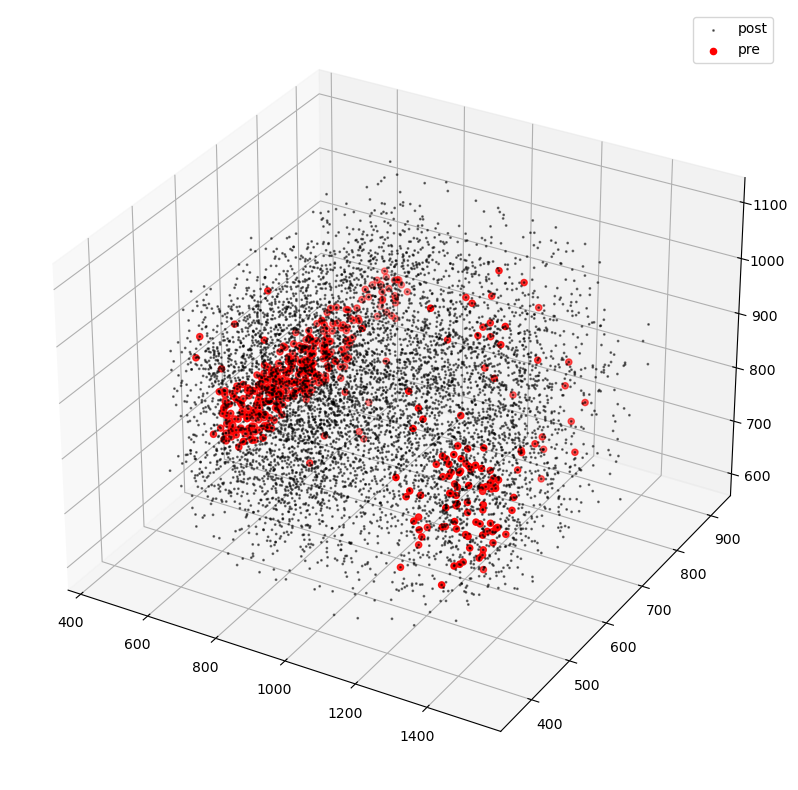

In [159]:
xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xpost, ypost, zpost, label='post', alpha=0.5, s=1, color='black')
ax.scatter(xpre, ypre, zpre, label='pre',color='red')
ax.legend()
plt.savefig('prepostData.png',bbox_inches='tight',dpi=200)
plt.show()

In [22]:
Npre = len(pre_set)
print(Npre)
Npost = len(post_set)
print(Npost)

459
7076


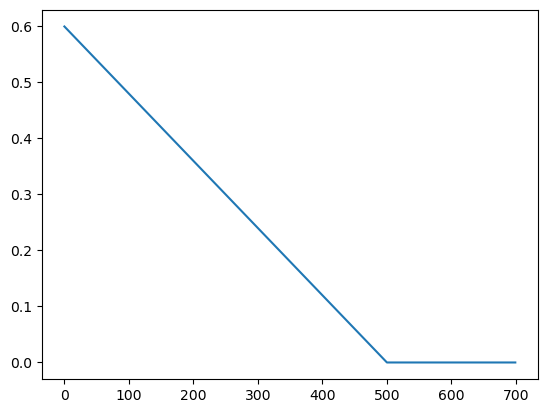

In [23]:
def getDists3Dmod(pre_set, post_set, pre_ref): # modified to account for 
    pos_ref = pre_set[pre_ref,:]
    x_ref = pos_ref[0]
    y_ref = pos_ref[1]
    z_ref = pos_ref[2]
    x_posts = post_set[:,0]
    y_posts = post_set[:,1]
    z_posts = post_set[:,2]
    dists = (x_ref - x_posts)**2 + (y_ref - y_posts)**2 + (z_ref - z_posts)**2
    dists = np.sqrt(dists)
    return dists

wax = lambda beta, d, d0: beta*np.exp(-d/d0)
linear = lambda d, d0, pmax: (d<d0)*(-pmax*d/d0 + pmax)

d = np.arange(0,700,1)

d0 = 500
pmax = 0.6
pvec = linear(d, d0, pmax)

plt.plot(d,pvec)

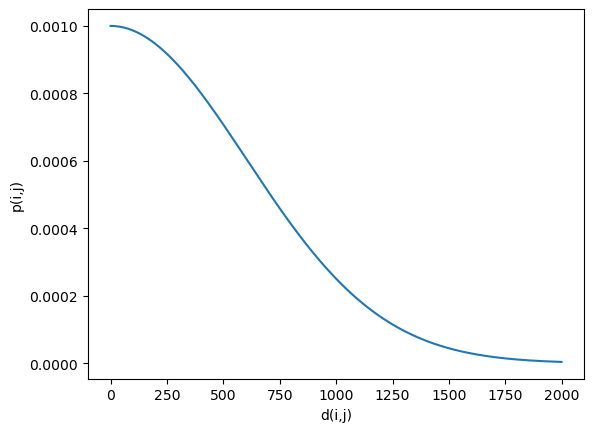

In [162]:
wax = lambda beta, d, d0: beta*np.exp(-d/d0)
linear = lambda d, d0, pmax: (d<d0)*(-pmax*d/d0 + pmax)
gauss = lambda d, d0, pmax: pmax*np.exp(-d**2/d0**2)

d = np.arange(0,2000,1)

d0 = 850
pmax = 0.001
pvec = gauss(d, d0, pmax)

plt.ylabel('p(i,j)')
plt.xlabel('d(i,j)')
plt.plot(d,pvec)
plt.savefig('gauss.png',bbox_inches='tight',dpi=200)
plt.show()

In [57]:
p

0.00931522955220565

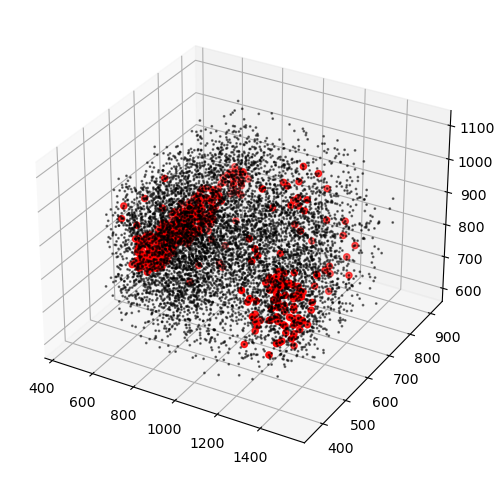

In [198]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
ax.scatter(xpost, ypost, zpost, label='post', alpha=0.5, s=1, color='black')
ax.scatter(xpre, ypre, zpre, label='pre',color='red')

# beta = 1
# d0 = 20
d0 = 1200
pmax = 0.0005

# pvec = linear(d, d0, pmax)

Awax_mod = np.zeros((N,N))
for pre_nrn in range(Npre):
    pre_idx = pre_nrn
    dists = getDists3Dmod(pre_set, post_set, pre_idx)
    probs = gauss(dists, d0, pmax)
    # print(probs)
    # print(len(probs))
    p = np.random.rand(len(probs))
    conn_idcs = np.argwhere(probs>p)
    
    # print(conn_idcs)
    
    xpre_pos = xpre[pre_idx]
    ypre_pos = ypre[pre_idx]
    zpre_pos = zpre[pre_idx]
    j = 0
    for conn_idx in conn_idcs:
        post_idx = conn_idx[0]
        # print(post_idx)
        Awax_mod[pre_idx, post_idx] = 1
#         if j % 2 == 0:  
#             xpost_pos = xpost[post_idx]
#             dx = xpost_pos - xpre_pos

#             ypost_pos = ypost[post_idx]
#             dy = ypost_pos - ypre_pos

#             zpost_pos = zpost[post_idx]
#             dz = zpost_pos - zpre_pos

#             ax.arrow3D(xpre_pos, ypre_pos, zpre_pos,
#                        dx  , dy  , dz  ,
#                        mutation_scale=0.1,
#                        arrowstyle="-|>",
#                        ec='blue',
#                        fc='blue',
#                        alpha=0.1)
#         j += 1
            
plt.savefig('gauss_spatial.png',bbox_inches='tight',dpi=200)
plt.show()

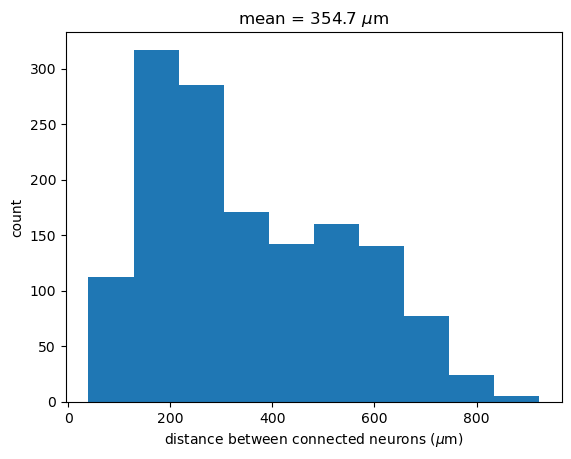

In [199]:
def getConnectedDistancesMod(pre_set,post_set,A):
    N = len(pos)
    D = []
    pre_indcs, post_indcs = np.argwhere(A>0)[:,0], np.argwhere(A>0)[:,1]
    for i, j in zip(pre_indcs, post_indcs):
        # pos_pre = pos[i,:]
        # pos_post= pos[j,:]
        xpre = pre_set[i,0]
        ypre = pre_set[i,1]
        zpre = pre_set[i,2]
        xpost= post_set[j,0]
        ypost= post_set[j,1]
        zpost= post_set[j,2]
        d = (xpre - xpost)**2 + (ypre - ypost)**2 + (zpre - zpost)**2
        d = np.sqrt(d)
        D.append(d)
    return D
pos = all_positions
Dwax_mod = getConnectedDistancesMod(pre_set,post_set,Awax_mod)
# Dwax_mod = np.array(Dwax_mod)
# print(Dwax_mod.shape)
m = np.mean(Dwax_mod)
# plt.yscale('log')
plt.title(f'mean = {m:.4} $\mu$m')
plt.hist(Dwax_mod)
plt.xlabel(r'distance between connected neurons ($\mu$m)')
plt.ylabel('count')
plt.savefig('distanceHist_Dgauss.png',bbox_inches='tight',dpi=200)
plt.show()
# print(np.mean(D_rawData))

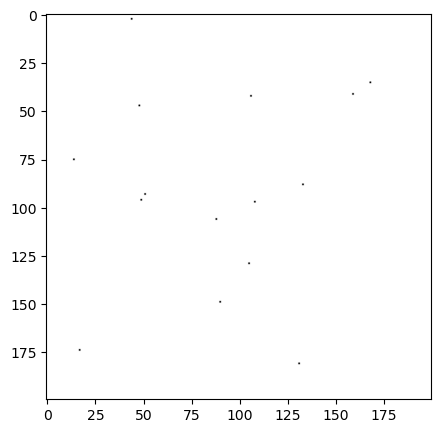

In [200]:
fig,ax = plt.subplots(figsize=(5,5))
pos = ax.imshow(Awax_mod[:200,:200],cmap='Greys')
# fig.colorbar(pos)
plt.show()

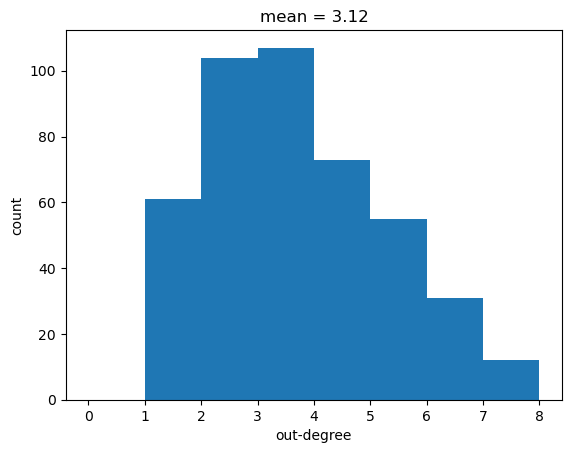

In [201]:
dout = np.sum(Awax_mod,axis=1)
plt.hist(dout[dout!=0],bins=np.arange(min(dout),max(dout)+1,1))
dout_avg = np.sum(dout)/Npre
# plt.yscale('log')
plt.title(f'mean = {dout_avg:.3}')
# plt.title(f'mean = {dout_avg}')
plt.xlabel('out-degree')
plt.ylabel('count')
plt.savefig('outDegHist_gauss.png',bbox_inches='tight',dpi=200)
plt.show()

In [168]:
pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])

In [169]:
positions.shape

(24782, 2)

In [170]:
len(pre_post_IDs)

24782

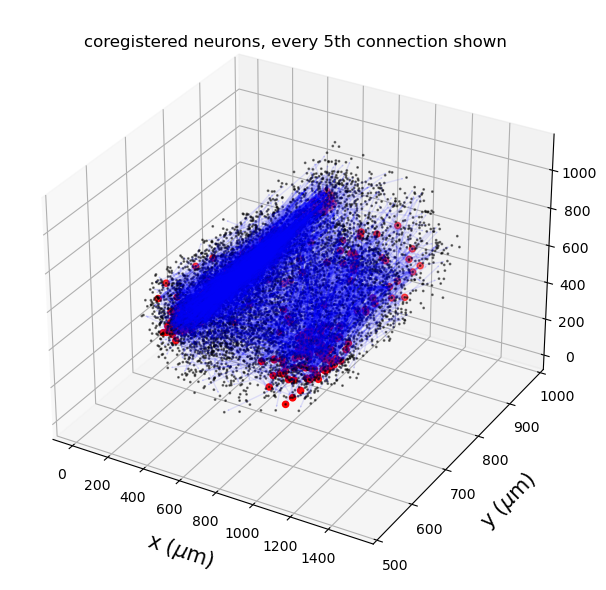

In [172]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ntoplot = 100 # number connections to plot

xpre_pos = []
xpost_pos= []
ypre_pos = []
ypost_pos= []
zpre_pos = []
zpost_pos= []

A_rawData = np.zeros((N_unique_nrns,N_unique_nrns))

# for ci in range(len(pre_post_IDs)):
# for ci in range(ntoplot):
for ci in range(len(pre_post_IDs)):
    if ci % 5 == 0:
        pre_pos = positions[ci,0]
        post_pos= positions[ci,1]
        xpre = pre_pos[0]
        xpre_pos.append(xpre)
        ypre = pre_pos[1]
        ypre_pos.append(ypre)
        zpre = pre_pos[2]
        zpre_pos.append(zpre)

        xpost= post_pos[0]
        xpost_pos.append(xpost)
        ypost= post_pos[1]
        ypost_pos.append(ypost)
        zpost= post_pos[2]
        zpost_pos.append(zpost)

        dx = xpost - xpre
        dy = ypost - ypre
        dz = zpost - zpre

        ax.arrow3D(xpre , ypre , zpre,
                   dx   , dy   , dz  ,
                   mutation_scale=1,
                   arrowstyle="-|>",
                   ec='blue',
                   fc='blue',
                   alpha=0.1)

# ax.dist = 13
plt.rcParams['axes.titley'] = 1.
# ax.set_title(f'proofread, coregistered neurons \n first {ntoplot} connections shown')
ax.set_title(f'coregistered neurons, every 5th connection shown')
ax.set_xlabel(r'x ($\mu$m)',labelpad=10,fontsize=15)
ax.tick_params(axis='x',labelsize=10)
ax.set_ylabel(r'y ($\mu$m)',labelpad=10,fontsize=15)
ax.tick_params(axis='y',labelsize=10)
ax.set_zlabel(r'z ($\mu$m)',labelpad=10,fontsize=15)
ax.tick_params(axis='z',labelsize=10)
# ax.set_xlim([400,1200])
ax.set_ylim([500,1000])
# ax.set_zlim([300,1000])
# ax.scatter(xpre_pos, ypre_pos, zpre_pos, s=50, color='red', label='pre')
# ax.scatter(xpost_pos, ypost_pos, zpost_pos, s=50, color='blue', label='post')
# ax.legend()
# ax.scatter(xpre_pos, ypre_pos, zpre_pos, s=10, color='red')
# ax.scatter(xpost_pos, ypost_pos, zpost_pos, s=10, color='red')
# x = all_positions[:,0]
# y = all_positions[:,1]
# z = all_positions[:,2]
# ax.scatter(x,y,z,s=1.5,color='red')
xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
ax.scatter(xpost, ypost, zpost, label='post', alpha=0.5, s=1, color='black')
ax.scatter(xpre, ypre, zpre, label='pre',color='red')
# ax.legend()
plt.tight_layout()
plt.savefig(f'spatial_EMnet_every5conns.png',bbox_inches="tight",dpi=200)
plt.show()

In [174]:
# get adjacency matrix from raw data

pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])
numConnections = pre_post_IDs.shape[0]
A_rawData = np.zeros((N_unique_nrns,N_unique_nrns)) # adjacency matrix
for i in range(numConnections):
    pre_post = pre_post_IDs[i,:]
    pre_idx = pre_post[0]
    post_idx = pre_post[1]
    A_rawData[pre_idx][post_idx] = 1


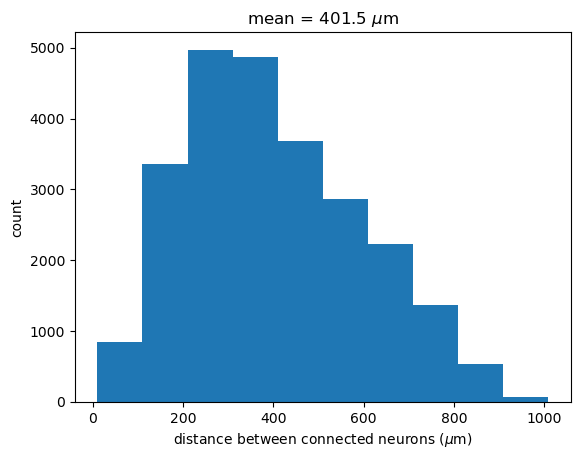

In [175]:
def getConnectedDistances(pos,A):
    N = len(pos)
    D = []
    pre_indcs, post_indcs = np.argwhere(A>0)[:,0], np.argwhere(A>0)[:,1]
    for i, j in zip(pre_indcs, post_indcs):
        pos_pre = pos[i,:]
        pos_post= pos[j,:]
        xpre = pos_pre[0]
        ypre = pos_pre[1]
        zpre = pos_pre[2]
        xpost= pos_post[0]
        ypost= pos_post[1]
        zpost= pos_post[2]
        d = (xpre - xpost)**2 + (ypre - ypost)**2 + (zpre - zpost)**2
        d = np.sqrt(d)
        D.append(d)
    return D
pos = all_positions
D_rawData = getConnectedDistances(pos,A_rawData)
m = np.mean(D_rawData)
plt.title(f'mean = {m:.4} $\mu$m')
plt.hist(D_rawData)
plt.xlabel(r'distance between connected neurons ($\mu$m)')
plt.ylabel('count')
plt.savefig('distanceHist_rawData.png',bbox_inches='tight',dpi=200)
plt.show()
# print(np.mean(D_rawData))

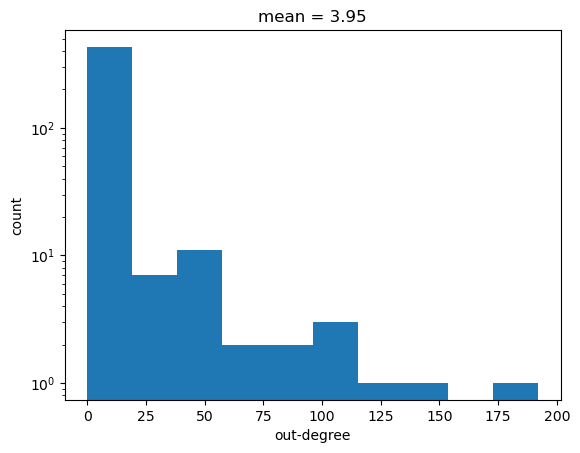

In [180]:
dout = np.sum(A_rawData,axis=1)[:Npre]
# dout_noZeros = dout[dout>0]
plt.hist(dout)
dout_avg = np.sum(dout)/Npre
plt.yscale('log')
# print(dout_avg)
plt.title(f'mean = {dout_avg:.3}')
plt.xlabel('out-degree')
plt.ylabel('count')
plt.savefig('outDegHist_rawData.png',bbox_inches='tight',dpi=200)
plt.show()

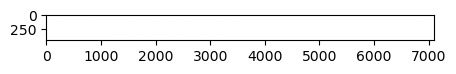

In [179]:
fig,ax = plt.subplots(figsize=(5,5))
pos = ax.imshow(A_rawData[:Npre,:],cmap='Greys')
# fig.colorbar(pos)
plt.show()

In [56]:
pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])
numConnections = pre_post_IDs.shape[0]
A = np.zeros((N_unique_nrns,N_unique_nrns)) # adjacency matrix
for i in range(numConnections):
    pre_post = pre_post_IDs[i,:]
    # print(pre_post)
    pre_idx = pre_post[0]
    post_idx = pre_post[1]
    A[pre_idx][post_idx] = 1

In [57]:
p = np.sum(A)/(Npre*Npost)
print(p)

0.007630198615467793


In [58]:
# get the number of motifs with dotmotif instead here
# n_con  = np.sum(A@A.T)
# n_div = np.sum(A.T@A)
# n_ch = np.sum(A@A)

con_motif = Motif("""
A -> C
B -> C
""")

div_motif = Motif("""
A -> B
A -> C
""")

chain_motif = Motif("""
A -> B
B -> C
""")

hostA = nx.from_numpy_array(A, create_using=nx.DiGraph)
executor = GrandIsoExecutor(graph=hostA)
con_results = executor.find(con_motif)
div_results = executor.find(div_motif)
chain_results = executor.find(chain_motif)
n_con = len(con_results)
n_div = len(div_results)
n_ch = len(chain_results)
print('done')

done


In [59]:
linear_cdf_vec = lambda x, x0: (x<x0)*(1 - x/x0)
wax = lambda beta, d, d0: beta*np.exp(-d/d0)

def getDists3D(pos, refidx):
    pos_ref = pos[refidx,:]
    pos_others = np.delete(pos, refidx, axis=0)
    x_ref = pos_ref[0]
    y_ref = pos_ref[1]
    z_ref = pos_ref[2]
    x_others = pos_others[:,0]
    y_others = pos_others[:,1]
    z_others = pos_others[:,2]
    dists = (x_ref - x_others)**2 + (y_ref - y_others)**2 + (z_ref - z_others)**2
    dists = np.sqrt(dists)
    return dists

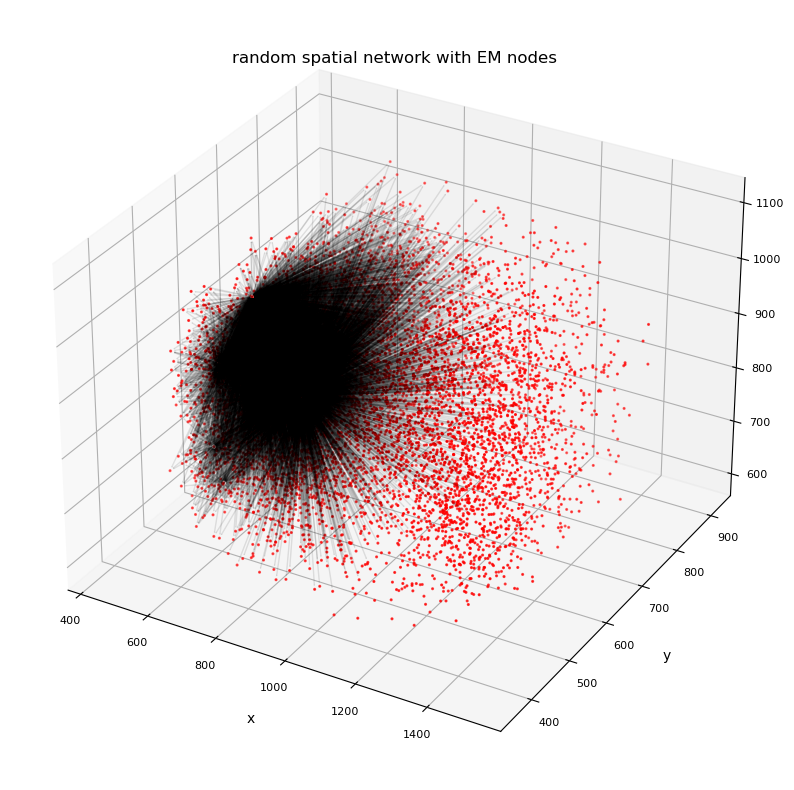

In [99]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

frac = 0.3
# N = int(frac*N_unique_nrns)
N = N_unique_nrns
# pos = all_positions[N:,:]
pos = all_positions
# xpos = pre_positions[:,0]
# ypos = pre_positions[:,1]


x = all_positions[:,0]
y = all_positions[:,1]
z = all_positions[:,2]
ax.scatter(x,y,z,s=1.5,color='red')
# x0 = 30
beta = 0.05
d0 = 150
Awax = np.zeros((N,N))
for refidx in range(Npre):
    dists = getDists3D(pos, refidx)
    probs = wax(beta, dists, d0)
    probs = np.insert(probs, refidx, 0) # no autapses
    p = np.random.rand()
    conn_idcs = np.argwhere(probs>p)
    for conn_idx in conn_idcs:
        post_idx = conn_idx[0]
        Awax[refidx,post_idx] = 1
        xpre = xpos[refidx]
        xpost= xpos[post_idx]
        dx = xpost - xpre
        ypre = ypos[refidx]
        ypost= ypos[post_idx]
        dy = ypost - ypre        
        zpre = zpos[refidx]
        zpost= zpos[post_idx]
        dz = zpost - zpre
        ax.arrow3D(xpre, ypre, zpre,
                   dx  , dy  , dz  ,
                   mutation_scale=0.1,
                   arrowstyle="-|>",
                   ec='black',
                   fc='black',
                   alpha=0.1)
# ax.dist = 13
plt.rcParams['axes.titley'] = 1
ax.set_title(f'random spatial network with EM nodes')
ax.set_xlabel(r'x',labelpad=10)
ax.tick_params(axis='x',labelsize=8)
ax.set_ylabel(r'y',labelpad=10)
ax.tick_params(axis='y',labelsize=8)
ax.set_zlabel(r'z',labelpad=10)
ax.tick_params(axis='z',labelsize=8)
plt.savefig('EMnodes_wax.png',bbox_inches='tight',dpi=200)
plt.show()

In [34]:
nseeds = 5

n_con_spatials = []
n_div_spatials = []
n_ch_spatials = []
x0 = 88
for s in range(nseeds):
    print(f'seed {s}')
    np.random.seed(s)
    A_spatial = np.zeros((N,N))
    for refidx in range(N):
        dists = getDists3D(pos, refidx)
        probs = linear_cdf_vec(dists, x0)
        # conns = np.array(probs>0, dtype=int)
        p = np.random.rand()
        conn_idcs = np.argwhere(probs>p)
        for conn_idx in conn_idcs:
            post_idx = conn_idx[0]
            A_spatial[refidx,post_idx] = 1

    hostAspatial = nx.from_numpy_array(A_spatial, create_using=nx.DiGraph)
    executor = GrandIsoExecutor(graph=hostAspatial)
    con_results_spatial = executor.find(con_motif)
    div_results_spatial = executor.find(div_motif)
    chain_results_spatial = executor.find(chain_motif)
    n_con_spatial = len(con_results_spatial)
    n_div_spatial = len(div_results_spatial)
    n_ch_spatial = len(chain_results_spatial)
    n_con_spatials = np.hstack((n_con_spatials,n_con_spatial))
    n_div_spatials = np.hstack((n_div_spatials,n_div_spatial))
    n_ch_spatials = np.hstack((n_ch_spatials,n_ch_spatial))

seed 0


KeyboardInterrupt: 

In [65]:
means = [np.mean(n_con_spatials),np.mean(n_div_spatials),np.mean(n_ch_spatials)]
stds = [np.std(n_con_spatials),np.std(n_div_spatials),np.std(n_ch_spatials)]

In [173]:
pch = n_ch/N**3            
pcon= n_con/N**3
pdiv= n_div/N**3

In [174]:
stds

[8147.22981141443, 14005.882112883857, 8958.922203033131]

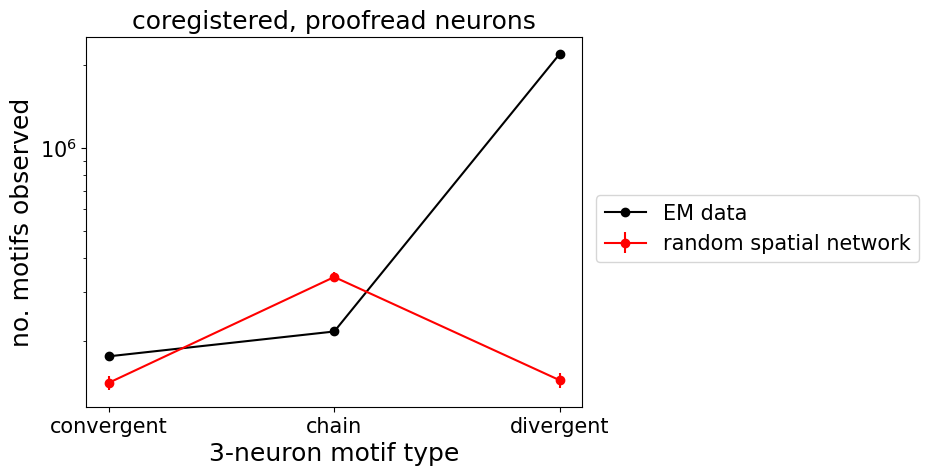

In [175]:
plt.rcParams['axes.titley'] = 1
plt.plot([n_con,n_ch,n_div],linestyle='-',marker='o',label='EM data',color='black')
# plt.plot([n_conER,n_divER,n_chER],linestyle='-',marker='o',label='Erdos-Reyni',color='red')
plt.errorbar([0,1,2],means,stds,linestyle='-',marker='o',label='random spatial network',color='red')
plt.title('coregistered, proofread neurons',fontsize=18)
# plt.yticks([25*10**3,25*10**5])
plt.yscale('log')
# plt.ylim([1,10**7])
plt.yticks(fontsizes=15)
plt.xticks([0,1,2],['convergent','chain','divergent'],fontsize=15)
plt.xlabel('3-neuron motif type',fontsize=18)
plt.ylabel('no. motifs observed',fontsize=18)
plt.legend(fontsize=15,bbox_to_anchor=(1.7,0.6))
plt.savefig('../results/prelim_ERresult_rectDot.png',bbox_inches='tight',dpi=200)
plt.show()

In [46]:
x0vec = np.arange(50,110,10)
nseeds = 3

big_n_con_spatials = []
big_n_div_spatials = []
big_n_ch_spatials = []

for x0 in x0vec:
    n_con_spatials = []
    n_div_spatials = []
    n_ch_spatials = []
    # x0 = 88
    print(f'x0 = {x0}')
    for s in range(nseeds):
        print(f'\tseed {s}')
        np.random.seed(s)
        A_spatial = np.zeros((N,N))
        for refidx in range(N):
            dists = getDists3D(pos, refidx)
            probs = linear_cdf_vec(dists, x0)
            # conns = np.array(probs>0, dtype=int)
            p = np.random.rand()
            conn_idcs = np.argwhere(probs>p)
            for conn_idx in conn_idcs:
                post_idx = conn_idx[0]
                A_spatial[refidx,post_idx] = 1

        hostAspatial = nx.from_numpy_array(A_spatial, create_using=nx.DiGraph)
        executor = GrandIsoExecutor(graph=hostAspatial)
        con_results_spatial = executor.find(con_motif)
        div_results_spatial = executor.find(div_motif)
        chain_results_spatial = executor.find(chain_motif)
        n_con_spatial = len(con_results_spatial)
        n_div_spatial = len(div_results_spatial)
        n_ch_spatial = len(chain_results_spatial)
        n_con_spatials = np.hstack((n_con_spatials,n_con_spatial))
        n_div_spatials = np.hstack((n_div_spatials,n_div_spatial))
        n_ch_spatials = np.hstack((n_ch_spatials,n_ch_spatial))
    if x0 == x0vec[0]:
        big_n_con_spatials = np.hstack((big_n_con_spatials,n_con_spatials))
        big_n_div_spatials = np.hstack((big_n_div_spatials,n_div_spatials))
        big_n_ch_spatials = np.hstack((big_n_ch_spatials,n_ch_spatials))
    else:
        big_n_con_spatials = np.vstack((big_n_con_spatials,n_con_spatials))
        big_n_div_spatials = np.vstack((big_n_div_spatials,n_div_spatials))
        big_n_ch_spatials = np.vstack((big_n_ch_spatials,n_ch_spatials))
print('done')

x0 = 50
	seed 0
	seed 1
	seed 2
x0 = 60
	seed 0
	seed 1
	seed 2
x0 = 70
	seed 0
	seed 1
	seed 2
x0 = 80
	seed 0
	seed 1
	seed 2
x0 = 90
	seed 0
	seed 1
	seed 2
x0 = 100
	seed 0
	seed 1
	seed 2
done


In [47]:
with open('big_n_con_spatials_3seeds.npy', 'wb') as f:
    np.save(f, big_n_con_spatials)
    
with open('big_n_div_spatials_3seeds.npy', 'wb') as f:
    np.save(f, big_n_div_spatials)
    
with open('big_n_ch_spatials_3seeds.npy', 'wb') as f:
    np.save(f, big_n_ch_spatials)

In [53]:
big_n_con_spatials_load = np.load('big_n_con_spatials_3seeds.npy')
big_n_div_spatials_load = np.load('big_n_div_spatials_3seeds.npy')
big_n_ch_spatials_load = np.load('big_n_ch_spatials_3seeds.npy')

In [48]:
# big_n_con_spatials.shape
con_means = np.mean(big_n_con_spatials,axis=1)
con_stds = np.std(big_n_con_spatials,axis=1)

In [54]:
con_means = np.mean(big_n_con_spatials_load,axis=1)
con_stds = np.std(big_n_con_spatials_load,axis=1)

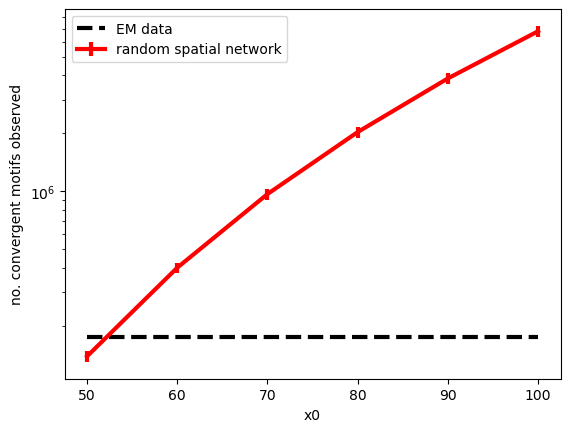

In [55]:
# n_con,n_ch,n_div
plt.plot(x0vec,n_con*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
plt.yscale('log')
plt.xlabel('x0')
plt.ylabel('no. convergent motifs observed')
plt.errorbar(x0vec,con_means,con_stds,label='random spatial network',color='red',linewidth=3)
plt.legend()
plt.savefig('conVx0.png',bbox_inches='tight',dpi=200)
plt.show()

In [50]:
div_means = np.mean(big_n_div_spatials,axis=1)
div_stds = np.std(big_n_div_spatials,axis=1)

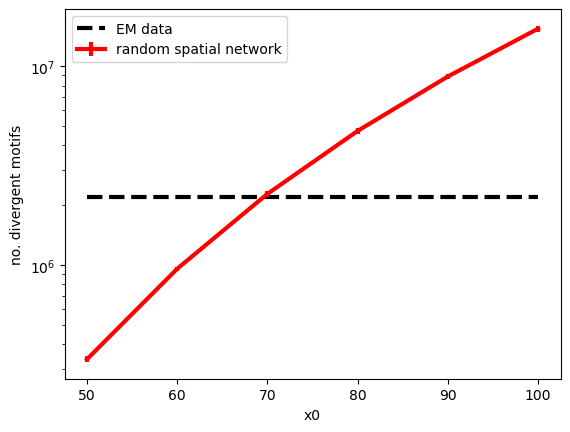

In [51]:
plt.plot(x0vec,n_div*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
plt.yscale('log')
plt.xlabel('x0')
plt.ylabel('no. divergent motifs')
plt.errorbar(x0vec,div_means,div_stds,label='random spatial network',color='red',linewidth=3)
plt.legend()
plt.savefig('divVx0.png',bbox_inches='tight',dpi=200)
plt.show()

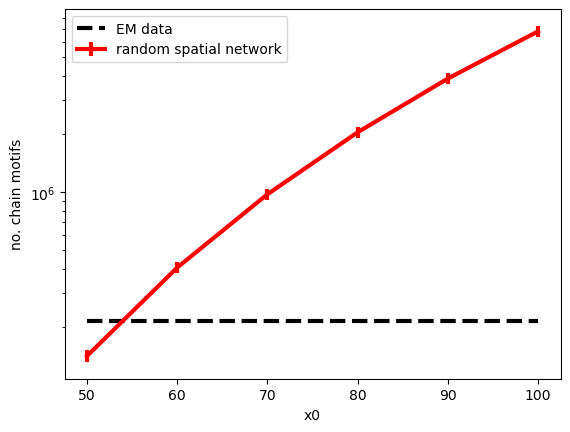

In [52]:
ch_means = np.mean(big_n_ch_spatials,axis=1)
ch_stds = np.std(big_n_ch_spatials,axis=1)
plt.plot(x0vec,n_ch*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
plt.yscale('log')
plt.xlabel('x0')
plt.ylabel('no. chain motifs')
plt.errorbar(x0vec,ch_means,ch_stds,label='random spatial network',color='red',linewidth=3)
plt.legend()
plt.savefig('chVx0.png',bbox_inches='tight',dpi=200)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## So what about cell types? 
Rather than define our own, lets use a cell type model that is available in MICrONS.  It's based on predicting the lables of the fine grain clustering that was reported in [Schneider-Mizell et al](https://www.biorxiv.org/content/10.1101/2023.01.23.525290v1) on the whole dataset using the soma and nucleus features and classifiers described et [Elabbady et al](https://www.biorxiv.org/content/10.1101/2022.07.20.499976v1). 
 This gives you broader coverage of cell types across the whole dataset. 

 </div>

In [85]:
client.materialize.get_tables()

['synapses_pni_2',
 'baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'connectivity_groups_v507',
 'proofreading_status_public_release',
 'allen_column_mtypes_v1',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'aibs_soma_nuc_exc_mtype_preds_v117',
 'baylor_log_reg_cell_type_coarse_v1',
 'apl_functional_coreg_forward_v5',
 'nucleus_detection_v0',
 'aibs_soma_nuc_metamodel_preds_v117',
 'coregistration_manual_v3']

In [87]:
client.materialize.get_table_metadata('nucleus_detection_v0')

{'created': '2020-11-02T18:56:35.530100',
 'table_name': 'nucleus_detection_v0__minnie3_v1',
 'valid': True,
 'id': 14621,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'nucleus_detection',
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minn

In [88]:
nuc_df = client.materialize.query_table('nucleus_detection_v0')
nuc_df.columns

Index(['id', 'created', 'superceded_id', 'valid', 'volume', 'pt_supervoxel_id',
       'pt_root_id', 'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [84]:
client.materialize.get_table_metadata('aibs_soma_nuc_exc_mtype_preds_v117')

{'created': '2023-02-10T20:34:39.185238',
 'table_name': 'aibs_soma_nuc_exc_mtype_preds_v117',
 'valid': True,
 'id': 14618,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'cell_type_reference',
 'schema_type': 'cell_type_reference',
 'user_id': '1077',
 'description': 'This table contains excitatory M-type predictions for cells throughout the entire dataset (Schneider-Mizell 2023 https://doi.org/10.1101/2023.01.23.525290). The model was trained with soma and nucleus features (Elabbady 2022 https://doi.org/10.1101/2022.07.20.499976). The cells selected were those that were predicted as excitatory based on the soma and nucleus feature trained metamodel - these prediction are available in the "aibs_soma_nuc_metamodel_preds_v117" table. This is a reference table where target_id refers to the unique nucleus id in the "nucleus_detection_v0" table. Classification_system refers to the coarse predictions from the soma and nucleus model and cell_type denotes the excitatory M-type prediction. 

In [86]:
client.materialize.get_table_metadata('aibs_soma_nuc_metamodel_preds_v117')

{'created': '2022-07-26T23:44:26.638883',
 'table_name': 'aibs_soma_nuc_metamodel_preds_v117',
 'valid': True,
 'id': 14622,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'cell_type_reference',
 'schema_type': 'cell_type_reference',
 'user_id': '1077',
 'description': 'This table contains cell-type predictions for cells throughout the entire dataset, based on a soma and nucleus feature trained metamodel (Elabbady 2022 https://doi.org/10.1101/2022.07.20.499976). This is a reference table where id refers to the unique nucleus id in the "nucleus_detection_v0" table. Classification_system refers to the coarse predictions and cell_type denotes noneuronal class and neuronal subclass predictions. Errors and soma-soma mergers have been filtered out. For questions please contact Leila Elabbady or Forrest Collman.[Note: This table "aibs_soma_nuc_metamodel_preds_v117" will update the "target_id" foreign_key when updates are made to the "nucleus_detection_v0" table] [Note: This table \'aibs_som

In [77]:
ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')

In [78]:
ct_df.head()

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,classification_system,cell_type,pt_position,bb_start_position,bb_end_position
0,255686,2020-09-28 22:40:42.632533+00:00,t,297.846047,88954888800920543,864691135568539372,35719,2023-02-10 20:56:50.913843+00:00,t,255686,aibs_coarse_excitatory,L3a,"[175760, 126480, 15504]","[nan, nan, nan]","[nan, nan, nan]"
1,524777,2020-09-28 22:45:05.521513+00:00,t,316.821012,105637160857796192,864691135355759567,44755,2023-02-10 20:58:01.326857+00:00,t,524777,aibs_coarse_excitatory,L4b,"[297040, 162864, 20055]","[nan, nan, nan]","[nan, nan, nan]"
2,204945,2020-09-28 22:44:25.115874+00:00,t,250.471875,84466820245155764,864691135208560505,52561,2023-02-10 20:58:57.753550+00:00,t,204945,aibs_coarse_excitatory,L6CT,"[142992, 241984, 19204]","[nan, nan, nan]","[nan, nan, nan]"
3,19116,2020-09-28 22:41:51.767906+00:00,t,301.426115,74737997899501359,864691135771677771,47137,2023-02-10 20:58:15.158371+00:00,t,19116,aibs_coarse_excitatory,L2b,"[72576, 108656, 20291]","[nan, nan, nan]","[nan, nan, nan]"
4,235619,2020-09-28 22:41:46.267950+00:00,t,275.799572,86646876455272842,864691135645393647,38969,2023-02-10 20:57:19.224311+00:00,t,235619,aibs_coarse_excitatory,L6b,"[158928, 231792, 15515]","[nan, nan, nan]","[nan, nan, nan]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Cell type columns
This has many of the same columns as coregistration,
because its also a reference to a nucleus

but it adds

* cell_type: the cell type string of the cell
* classification_system: a broader cell class description (uniformly aibs_coarse_excitatory here)

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

### Task 
How many cells of each type are there?
</div>

In [79]:
ct_df.cell_type.value_counts().sort_index()

cell_type
L2a     3430
L2b     2985
L3a     3264
L3b     2740
L3c     6945
L4a     8312
L4b     3264
L4c     2453
L5ET    2179
L5NP     755
L5a     2228
L5b     3243
L6CT    8526
L6a     2557
L6b     2153
L6c     3590
Name: count, dtype: int64

In [83]:
ct_df.columns

Index(['id_ref', 'created_ref', 'valid_ref', 'volume', 'pt_supervoxel_id',
       'pt_root_id', 'id', 'created', 'valid', 'target_id',
       'classification_system', 'cell_type', 'pt_position',
       'bb_start_position', 'bb_end_position'],
      dtype='object')

In [80]:
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

In [81]:
# lets look at a subset of these columns to understand what we have now
ct_merge_df[['index','session', 'scan_idx', 'field', 'cell_type', 'pt_root_id', 'target_id', 'pt_position']].head()

,index,session,scan_idx,field,cell_type,pt_root_id,target_id,pt_position
0,0,4,7,2,L2a,864691135348268503,516506,"[1184.832, 378.752, 632.12]"
1,1,4,7,2,L2a,864691135700505634,452329,"[1076.992, 395.328, 735.28]"
2,2,4,7,2,L2a,864691135776919981,451461,"[1099.456, 376.256, 881.84]"
3,3,4,7,2,L2a,864691135472842290,420222,"[1039.744, 389.44, 678.96]"
4,4,4,7,2,L2b,864691135349237975,420058,"[985.792, 383.424, 634.92]"


In [82]:
# have lost some few cells that we don't have cell types for
ct_merge_df.shape

(11582, 26)